In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
df = pd.read_csv('AB_Test_Results.csv')

In [3]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [5]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

Посмотрим есть ли пересечение в группах

Посмотрим есть ли пересечение среди групп тестирования

In [6]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()[1:]

VARIANT_NAME
2    1541
Name: count, dtype: int64

Видим, что 1541 состоят в двух группах одновременно, исправим

In [11]:
mask=df.groupby('USER_ID')['VARIANT_NAME'].nunique()==1
right_test=mask[mask]
right_test

USER_ID
2       True
4       True
5       True
6       True
9       True
        ... 
9990    True
9992    True
9993    True
9995    True
9998    True
Name: VARIANT_NAME, Length: 4783, dtype: bool

In [13]:
df=df[df['USER_ID'].isin(right_test.index)]

In [15]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

VARIANT_NAME
1    4783
Name: count, dtype: int64

Рассмотрим разброс дохода по группам:

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

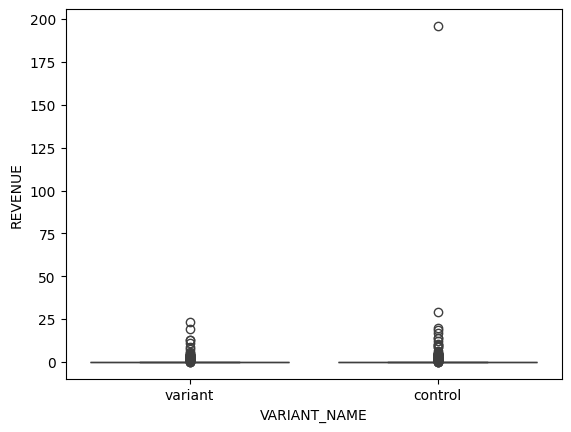

In [17]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

Видим явный выброс в контрольной группе, удалим его

In [19]:
df = df[df['REVENUE'] < 100]

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

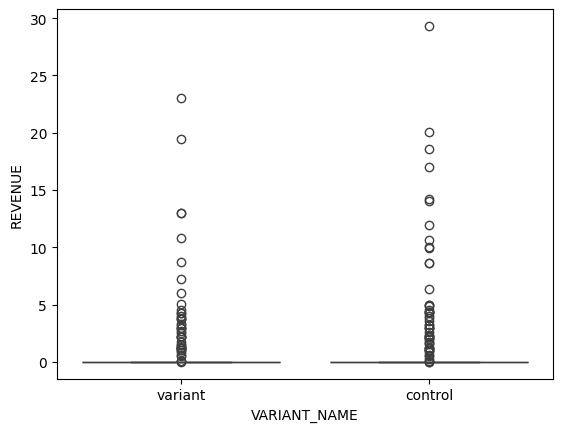

In [20]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

Это все еще малоинформативно, так как выше мы увидели, что как минимум 75% пользователей имеют доход 0, рассмотрим остальных

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

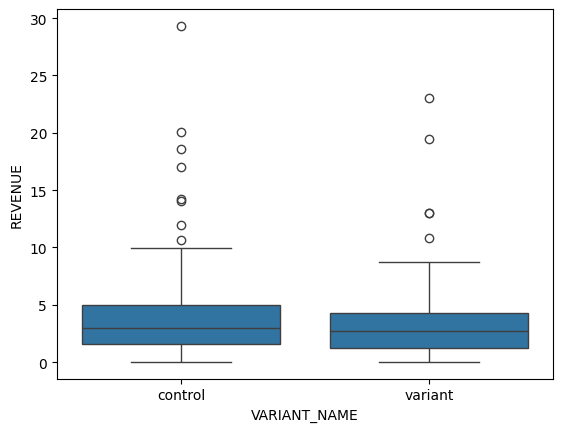

In [22]:
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])

Разберемся в причинах большого количества заказов с нулевым доходом: возможно о покупаетел создается запись независимо от его действий(допустим достаточно входа на сайт), а потом еще одна при реальной покупке. Проверим:

In [25]:
paying_users = df[df['REVENUE'] > 0]['USER_ID'].unique()
result = df[(df['REVENUE'] == 0) & (df['USER_ID'].isin(paying_users))]['USER_ID'].count()
result

np.int64(52)

Видим, что такое действительно возможно. Перегруппируем данные так, чтобы на одного пользователя приходилась одна запись с суммой его доходов

In [27]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


Рассмотрим статистические параметры у каждой группы внимательнее

In [52]:
stats = df.groupby('VARIANT_NAME').agg(
    unique_users=('USER_ID', 'nunique'),
    total_orders=('REVENUE', 'count'),
    total_revenue=('REVENUE', 'sum'),
    avg_order_value=('REVENUE', 'mean'),
    median_order_value=('REVENUE', 'median')
)

stats['orders_per_user'] = stats['total_orders'] / stats['unique_users']
stats['revenue_per_user'] = stats['total_revenue'] / stats['unique_users']


stats

,unique_users,total_orders,total_revenue,avg_order_value,median_order_value,orders_per_user,revenue_per_user
VARIANT_NAME,,,,,,,
control,2389,2389,274.55,0.114923,0.0,1.0,0.114923
variant,2393,2393,179.32,0.074935,0.0,1.0,0.074935


Видим что в тестовой группе все показатели ниже

Теперь рассмотрим отдельно заплативших пользователей:

In [54]:
paid_users_df = df.loc[df['REVENUE'] != 0]

paid_stat = paid_users_df.groupby('VARIANT_NAME').agg({
    'USER_ID': 'nunique',          
    'REVENUE': [
        'sum',                     
        'mean',                    
        'median',                  
        'count'                    
    ]
})

orders_per_paying_user = paid_stat[('REVENUE', 'count')] / paid_stat[('USER_ID', 'nunique')]

revenue_per_paying_user = paid_stat[('REVENUE', 'sum')] / paid_stat[('USER_ID', 'nunique')]

paid_stat[('per_user', 'orders')] = orders_per_paying_user
paid_stat[('per_user', 'revenue')] = revenue_per_paying_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

Опять видим сниженные показатели в тестовой группе, визуализируем:

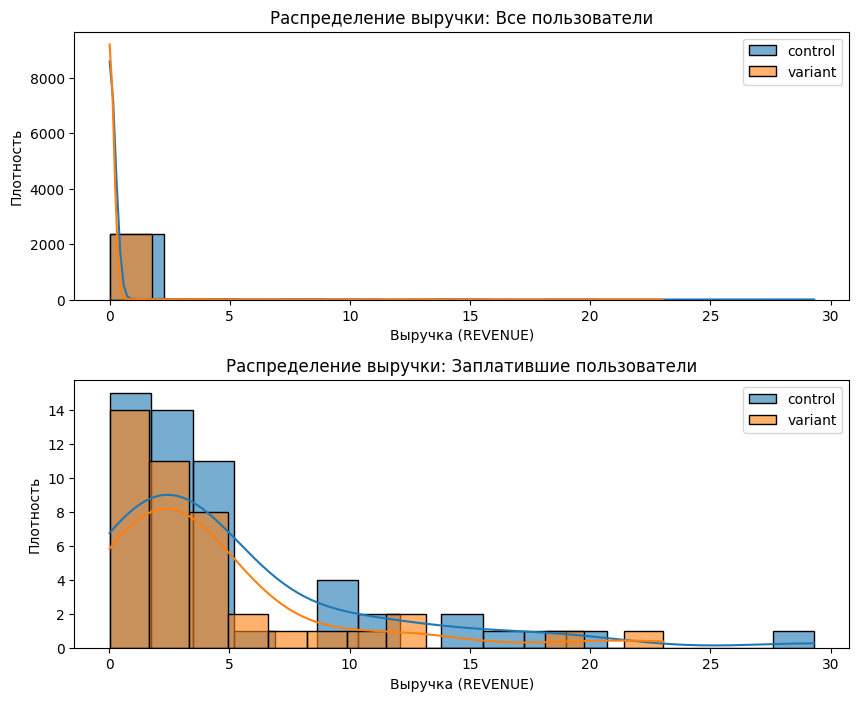

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

control_all = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']
variant_all = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE']

sns.histplot(control_all, ax=axes[0], label='control', kde=True, alpha=0.6)
sns.histplot(variant_all, ax=axes[0], label='variant', kde=True, alpha=0.6)
axes[0].set_title('Распределение выручки: Все пользователи')
axes[0].set_xlabel('Выручка (REVENUE)')
axes[0].set_ylabel('Плотность')
axes[0].legend()

control_paying = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE']
variant_paying = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE']

sns.histplot(control_paying, ax=axes[1], label='control', kde=True, alpha=0.6)
sns.histplot(variant_paying, ax=axes[1], label='variant', kde=True, alpha=0.6)
axes[1].set_title('Распределение выручки: Заплатившие пользователи')
axes[1].set_xlabel('Выручка (REVENUE)')
axes[1].set_ylabel('Плотность')
axes[1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

Проверим нормально ли распределены данные:

In [43]:
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=np.float64(0.06145986897942335), pvalue=np.float64(9.962810723092505e-76))

Видим, что pvalue мало => распределение не нормально, используем тест Mann-Whitney.

In [57]:
control_group = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']
variant_group = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE']
result = mannwhitneyu(variant_group, control_group)
result

MannwhitneyuResult(statistic=np.float64(2845109.0), pvalue=np.float64(0.24799555106821947))

In [58]:
paying_variant = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE']
paying_control = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE']
result = mannwhitneyu(paying_variant, paying_control)
result

MannwhitneyuResult(statistic=np.float64(1029.0), pvalue=np.float64(0.5314192217084708))

Видим, что pvalue>0.05 значит ни в платежной, ни в общей группе не можем утверждать о статистически значимых различиях

In [60]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [61]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [62]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

C:\Users\nicit\AppData\Local\Temp\ipykernel_14848\2882962051.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control, axis=1), shade=True, label='Контрольная группа', ax=ax)
C:\Users\nicit\AppData\Local\Temp\ipykernel_14848\2882962051.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant, axis=1), shade=True, label='Тестовая группа', ax=ax)


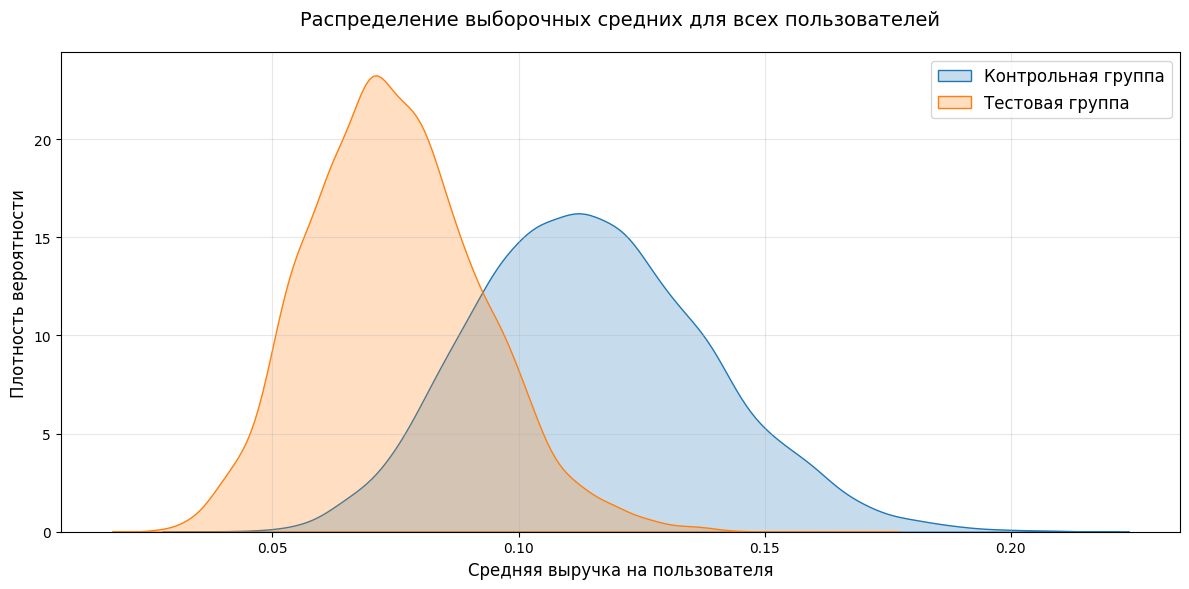

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(np.mean(control, axis=1), shade=True, label='Контрольная группа', ax=ax)
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='Тестовая группа', ax=ax)

ax.set_title('Распределение выборочных средних для всех пользователей', fontsize=14, pad=20)
ax.set_xlabel('Средняя выручка на пользователя', fontsize=12)
ax.set_ylabel('Плотность вероятности', fontsize=12)

ax.legend(fontsize=12)

ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

C:\Users\nicit\AppData\Local\Temp\ipykernel_14848\1073008309.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='Контрольная группа', ax=ax, color='blue', alpha=0.7)
C:\Users\nicit\AppData\Local\Temp\ipykernel_14848\1073008309.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='Тестовая группа', ax=ax, color='orange', alpha=0.7)


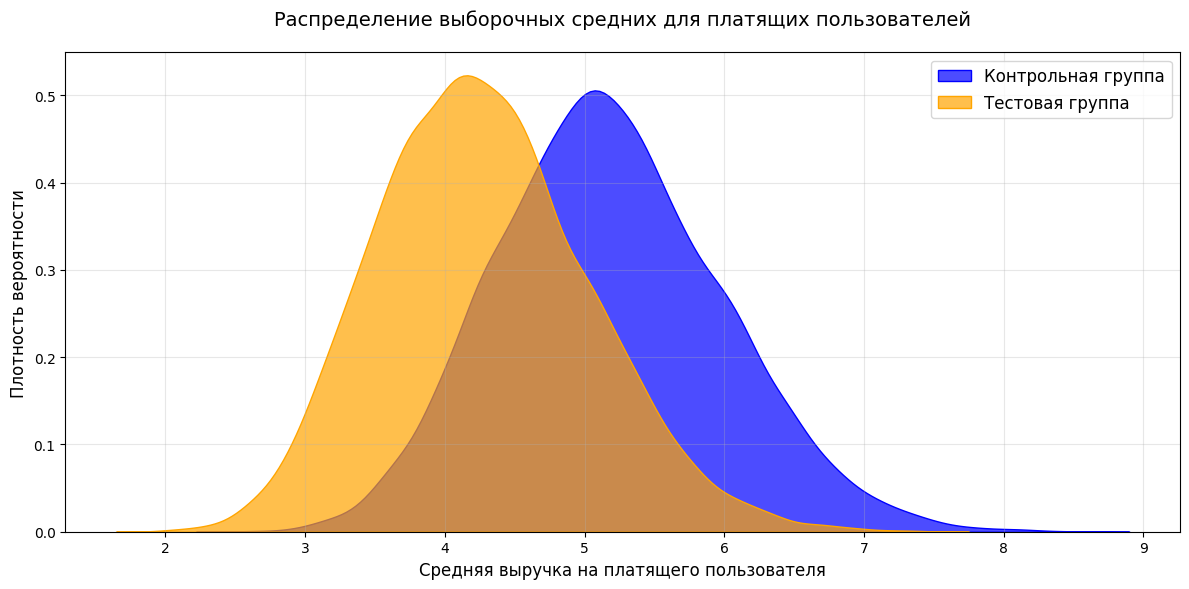

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='Контрольная группа', ax=ax, color='blue', alpha=0.7)
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='Тестовая группа', ax=ax, color='orange', alpha=0.7)

ax.set_title('Распределение выборочных средних для платящих пользователей', fontsize=14, pad=20)
ax.set_xlabel('Средняя выручка на платящего пользователя', fontsize=12)
ax.set_ylabel('Плотность вероятности', fontsize=12)

ax.legend(fontsize=12)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Чтобы сделать выводы об изменениях между группами ab-теста, в данные были внесены следующие изменения:

Пользователи из двух групп ab-теста были исключены для более выраженного эффекта изменений. User_id=3342 был исключен, поскольку в условиях ограниченной информации он представляет собой сильный выброс в полученной выборке. Пользователи взяты в качестве экспериментальной единицы, затем данные сгруппированы по каждому пользователю и доходу и суммированы для каждого пользователя, чтобы получить одну запись на пользователя. Несмотря на то, что доход в тестовой группе значительно снизился, статистически значимых изменений между группами ab-теста не наблюдалось, как среди всех пользователей, так и только среди платящей аудитории. Для более глубокого анализа будут полезны данные A/A-теста и дальнейшее изучение мощности критериев.